In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


**Важно:**  я добавил в исходные данные информацию до августа 2018 включительно, поэтому используйте csv из архива.

In [2]:
salary  = pd.read_csv("WAG_C_M.csv", ";", index_col = ["month"], parse_dates=['month'], dayfirst = "true")
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


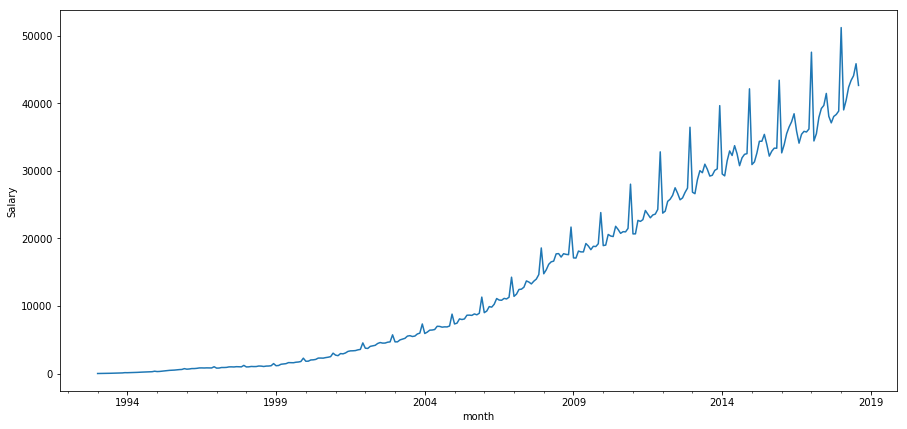

In [16]:
salary  = pd.read_csv("WAG_C_M.csv", ";", index_col = ["month"], parse_dates=['month'], dayfirst = "true")
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel("Salary")
pylab.show()

Dick-Fuller criteria: 0.998892


<Figure size 1080x720 with 0 Axes>

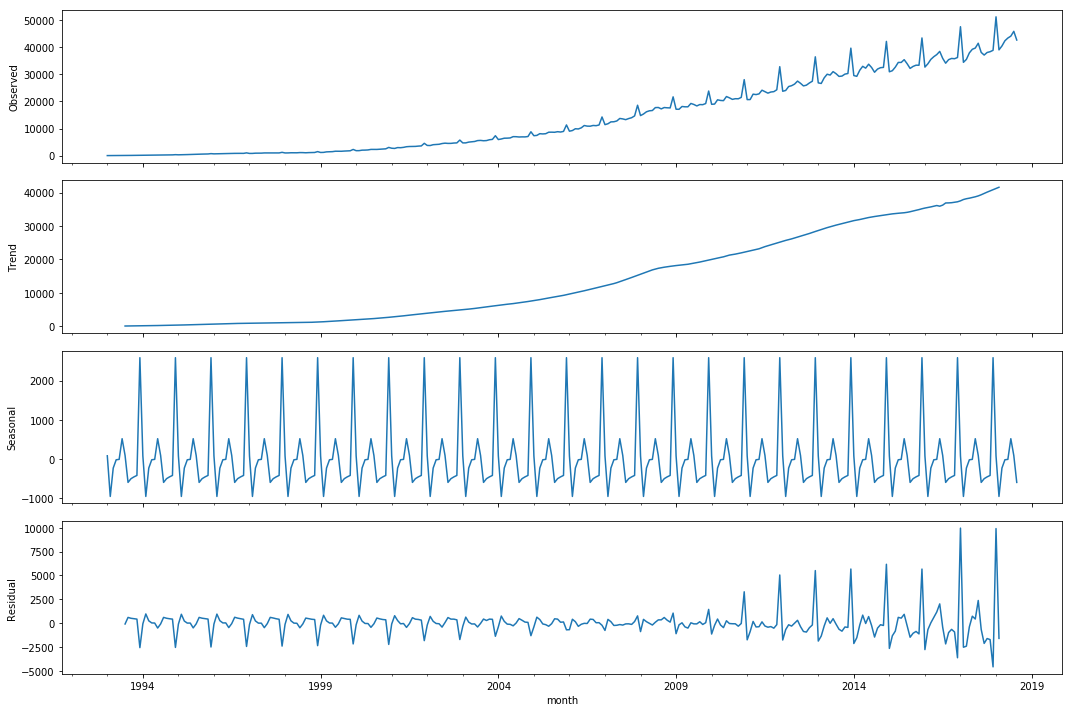

In [20]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
#pylab.show()
print("Dick-Fuller criteria: %f" % sm.tsa.adfuller(salary.WAG_C_M)[1])

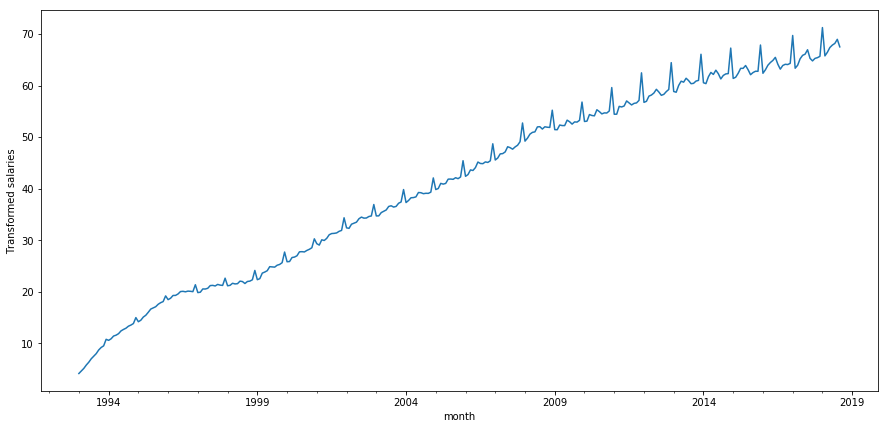

Optimal Lambda: 0.280807
Dick-Fuller criteria: 0.719330


In [26]:
salary["WAG_C_M_boxcox"], lmbd = stats.boxcox(salary.WAG_C_M) 
plt.figure(figsize(15,7))
salary.WAG_C_M_boxcox.plot()
plt.ylabel("Transformed salaries")
pylab.show()
print("Optimal Lambda: %f" % lmbd)
print("Dick-Fuller criteria: %f" % sm.tsa.adfuller(salary.WAG_C_M_boxcox)[1])

Dick-Fuller: 0.011270


<Figure size 1080x504 with 0 Axes>

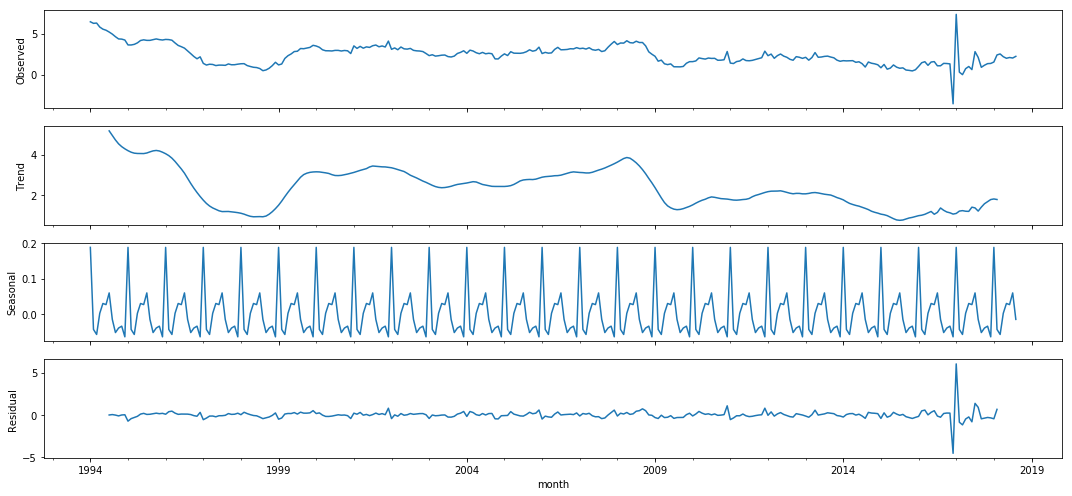

In [31]:
salary["WAG_C_M_boxcox_diff"] = salary.WAG_C_M_boxcox - salary.WAG_C_M_boxcox.shift(12)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(salary.WAG_C_M_boxcox_diff[12:]).plot()
print("Dick-Fuller: %f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_boxcox_diff[12:])[1])

Dick-Fuller: 0.000000


<Figure size 1080x504 with 0 Axes>

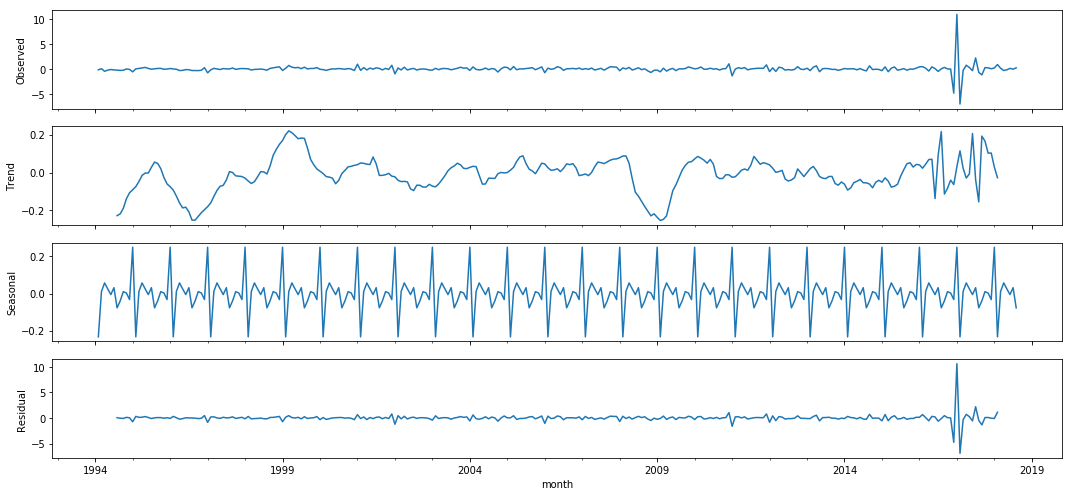

In [32]:
salary["WAG_C_M_boxcox_diff2"] = salary.WAG_C_M_boxcox_diff - salary.WAG_C_M_boxcox_diff.shift(1)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(salary.WAG_C_M_boxcox_diff2[13:]).plot()
print("Dick-Fuller: %f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_boxcox_diff2[13:])[1])

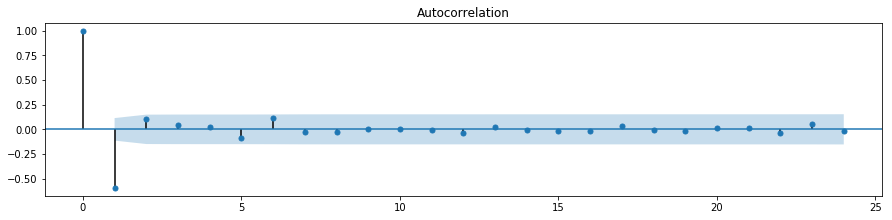

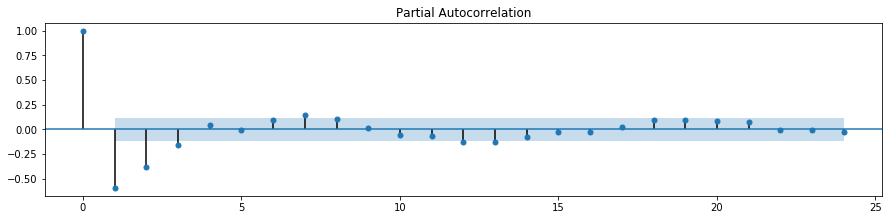

In [44]:
plt.figure(figsize(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_C_M_boxcox_diff2[13:].values.squeeze(), lags = 24, ax = ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_boxcox_diff2[13:].values.squeeze(), lags = 24, ax = ax)
pylab.show()

Начальные приближения: q = 0, Q = 1, p = 1, P = 3

In [45]:
ps = range(0,2)
Ps = range(0,4)
Qs = range(0,1)
qs= range(0,2)
d = 1
D = 1

In [46]:
parameters = product(ps,Ps,qs,Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [58]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_C_M_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 2, 1, 0))
('wrong parameters:', (0, 3, 1, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
Wall time: 6.09 s


In [59]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
10  (1, 3, 1, 0)  572.370194
9   (1, 3, 0, 0)  574.358509
8   (1, 1, 1, 0)  589.152957
7   (1, 1, 0, 0)  589.224042
1   (0, 1, 0, 0)  608.471810


In [60]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  308
Model:             SARIMAX(1, 1, 3)x(1, 1, 0, 12)   Log Likelihood                -280.185
Date:                            Sun, 09 Sep 2018   AIC                            572.370
Time:                                    19:56:30   BIC                            594.751
Sample:                                01-01-1993   HQIC                           581.319
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0772      0.219      0.353      0.724      -0.352       0.507
ma.L1         -1.0139      0.234   

Критерий Стьюдента: p=0.344319
Критерий Дики-Фуллера: p=0.000000


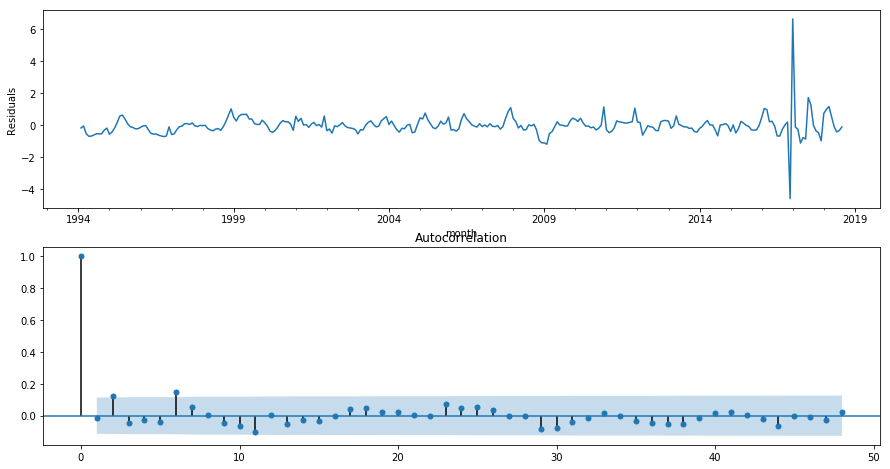

In [61]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

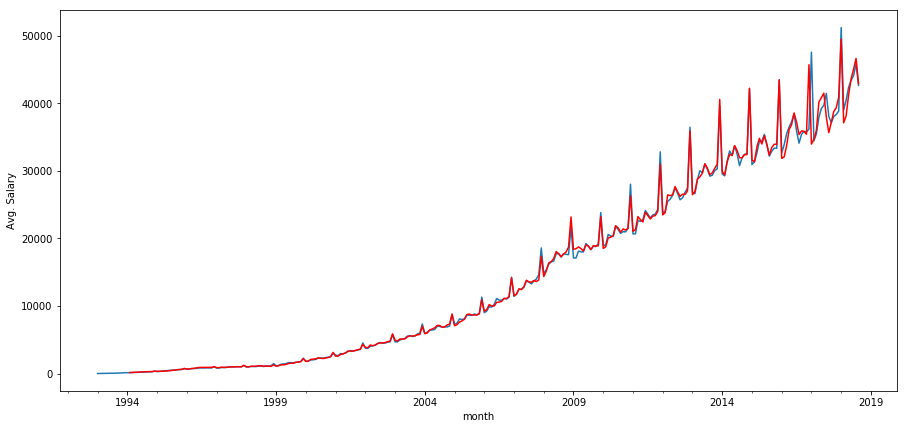

In [62]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbd)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Avg. Salary')
pylab.show()

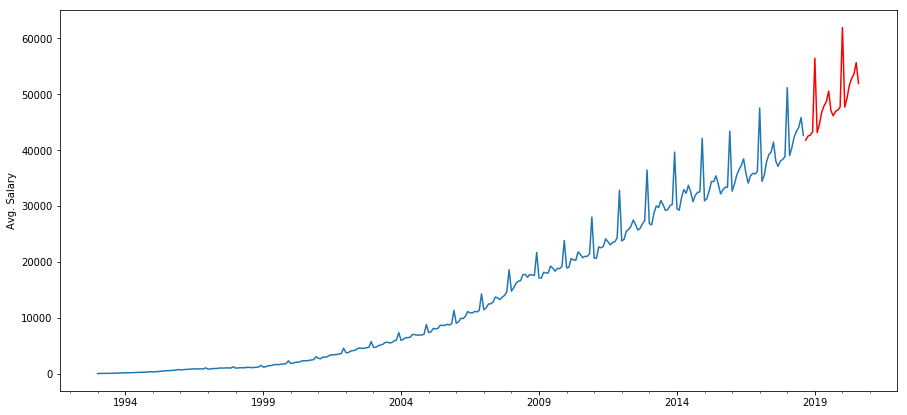

In [73]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2018-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=308, end=332), lmbd)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Avg. Salary')
pylab.show()